<a href="https://colab.research.google.com/github/georgette-femerling/ACSBootcamp_Clustering/blob/main/Clustering_of_scRNA_seq_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Analysis of Single-cell RNA-seq data using Scanpy

## Introduction

All cells have the same DNA sequence.

### Central Dogma of Molecular biology


> First coined by Francis Crick in 1957 and then re-stated in 1970

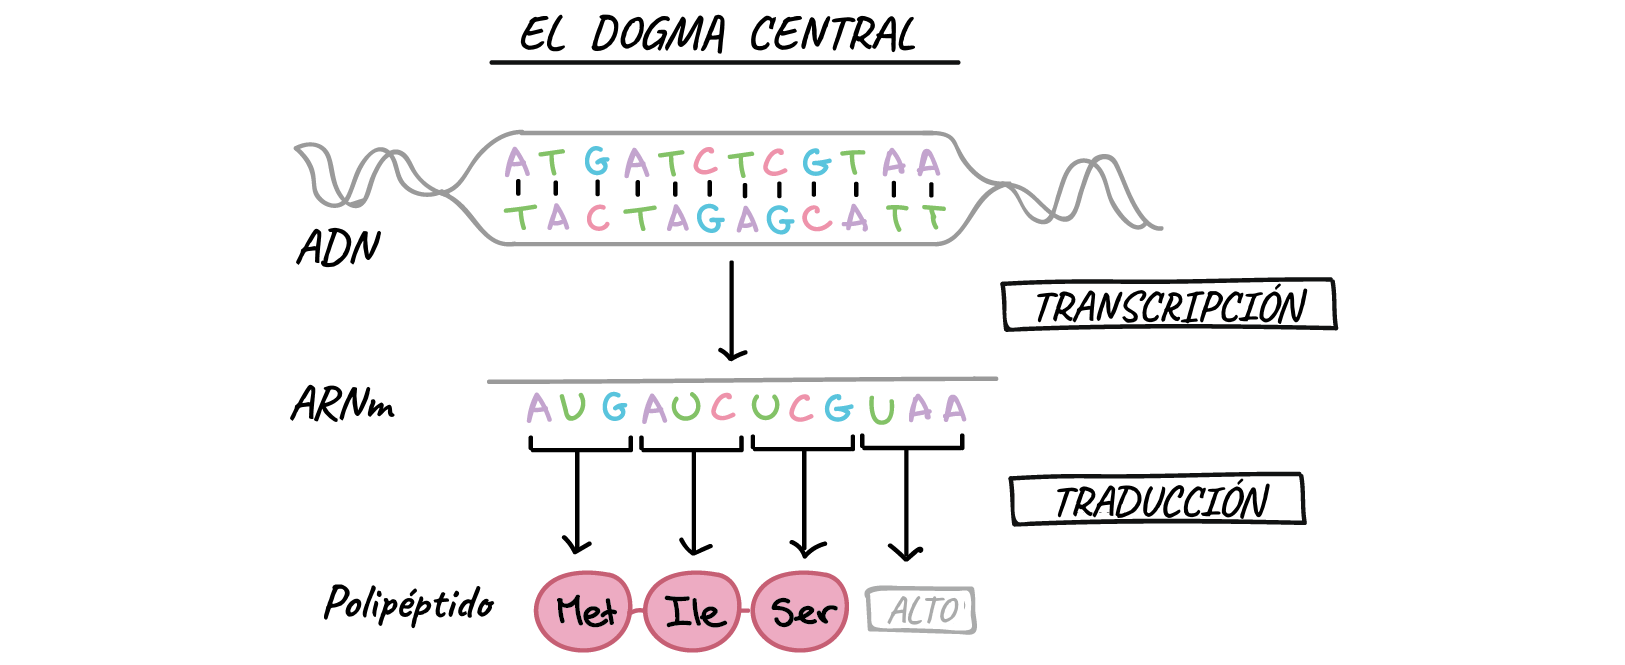






> Although they have the same genetic code, different types of cells express different genes.

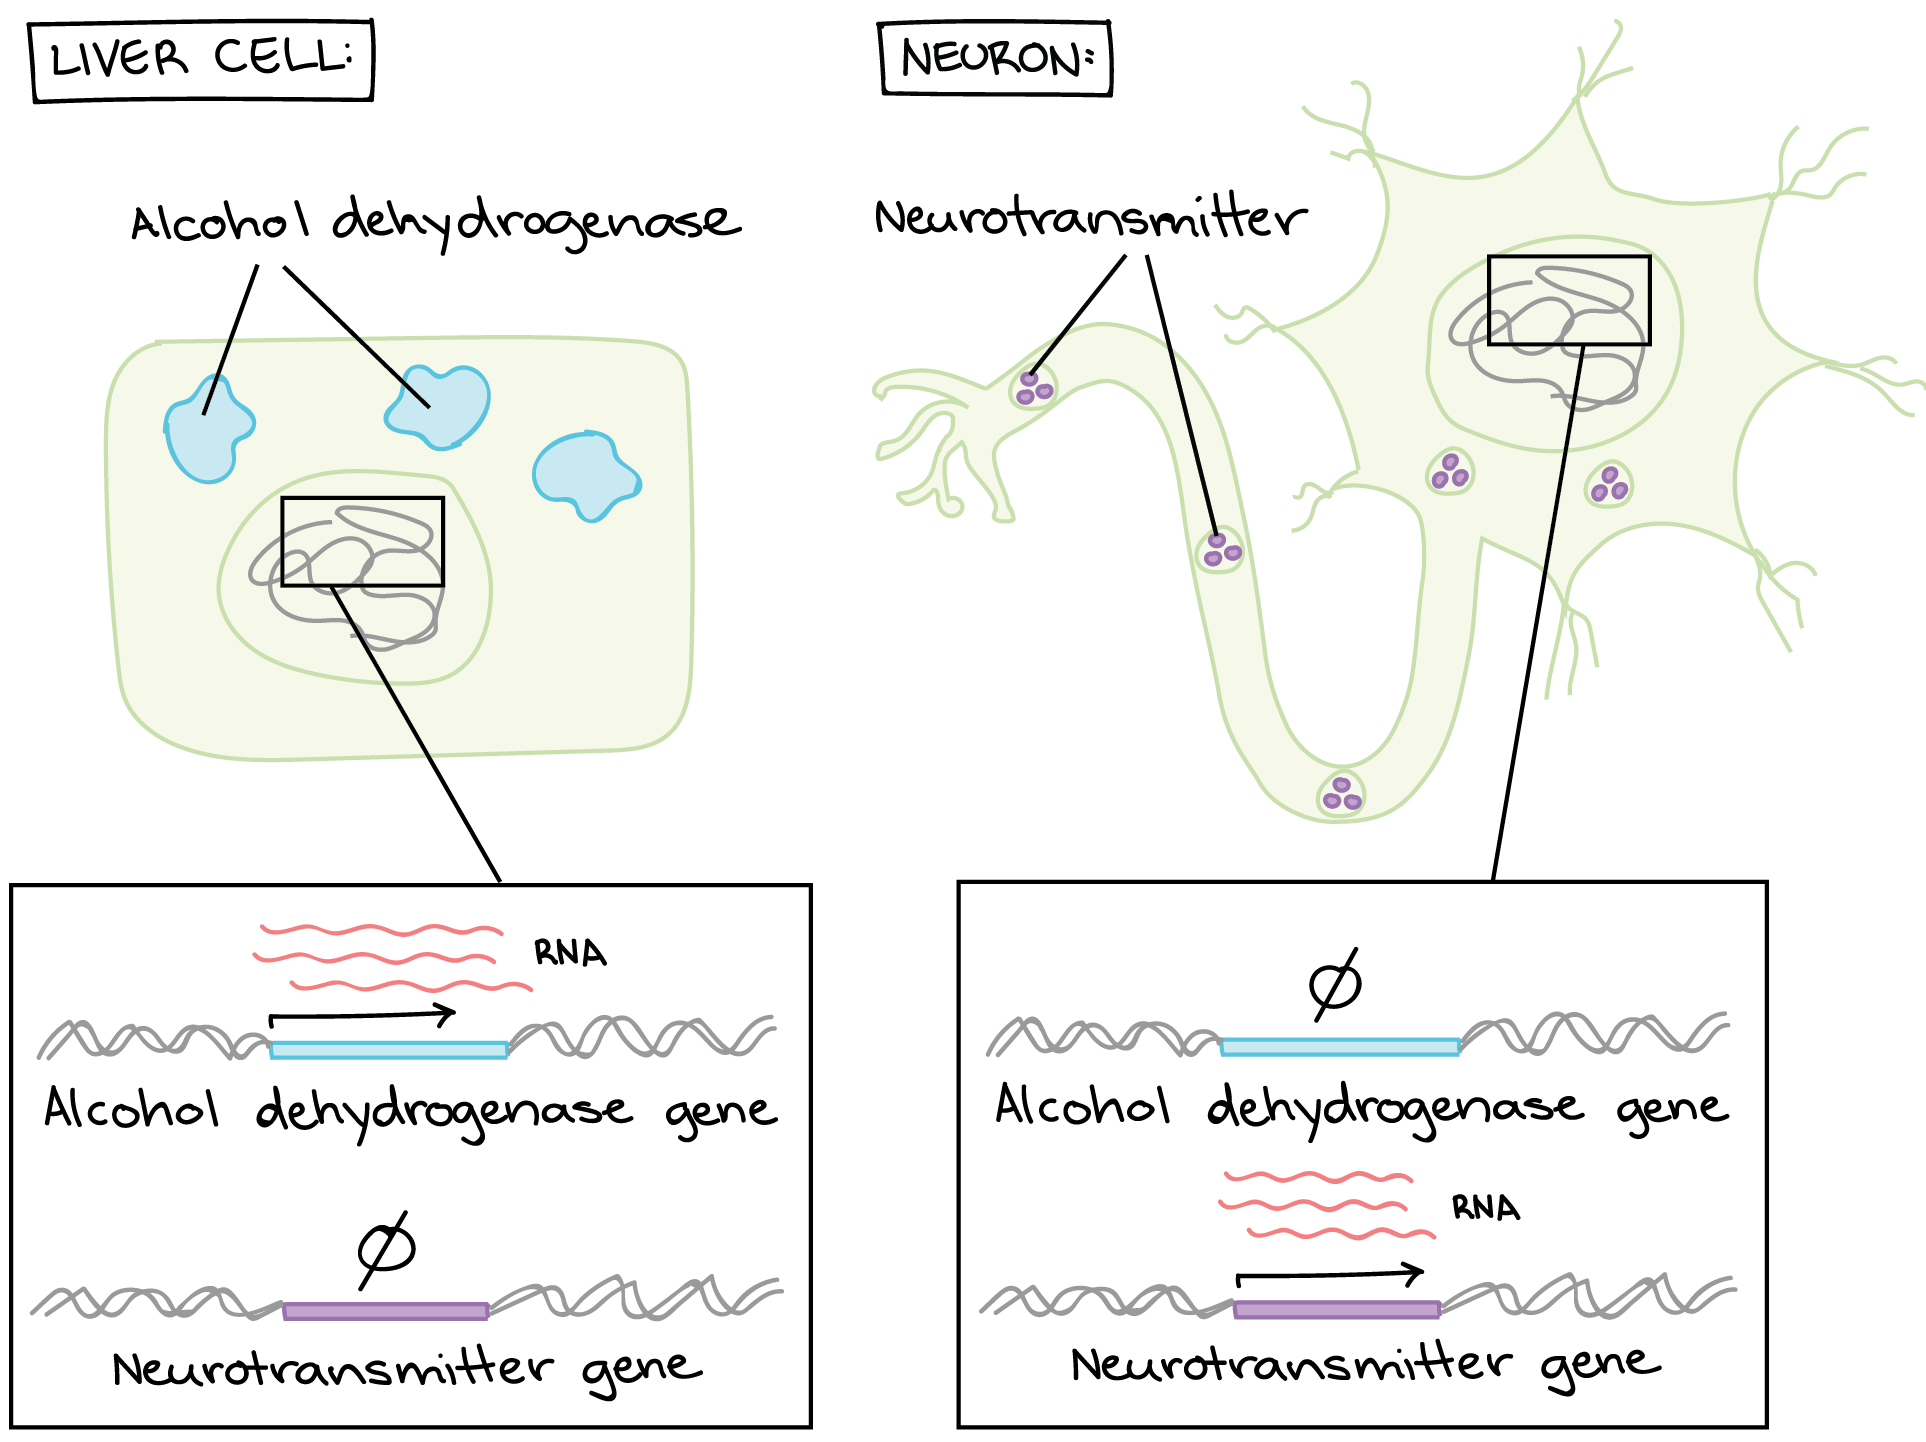



### High-throughput sequecing, RNA-seq and scRNA-seq

How do we get to know the sequence of the code?

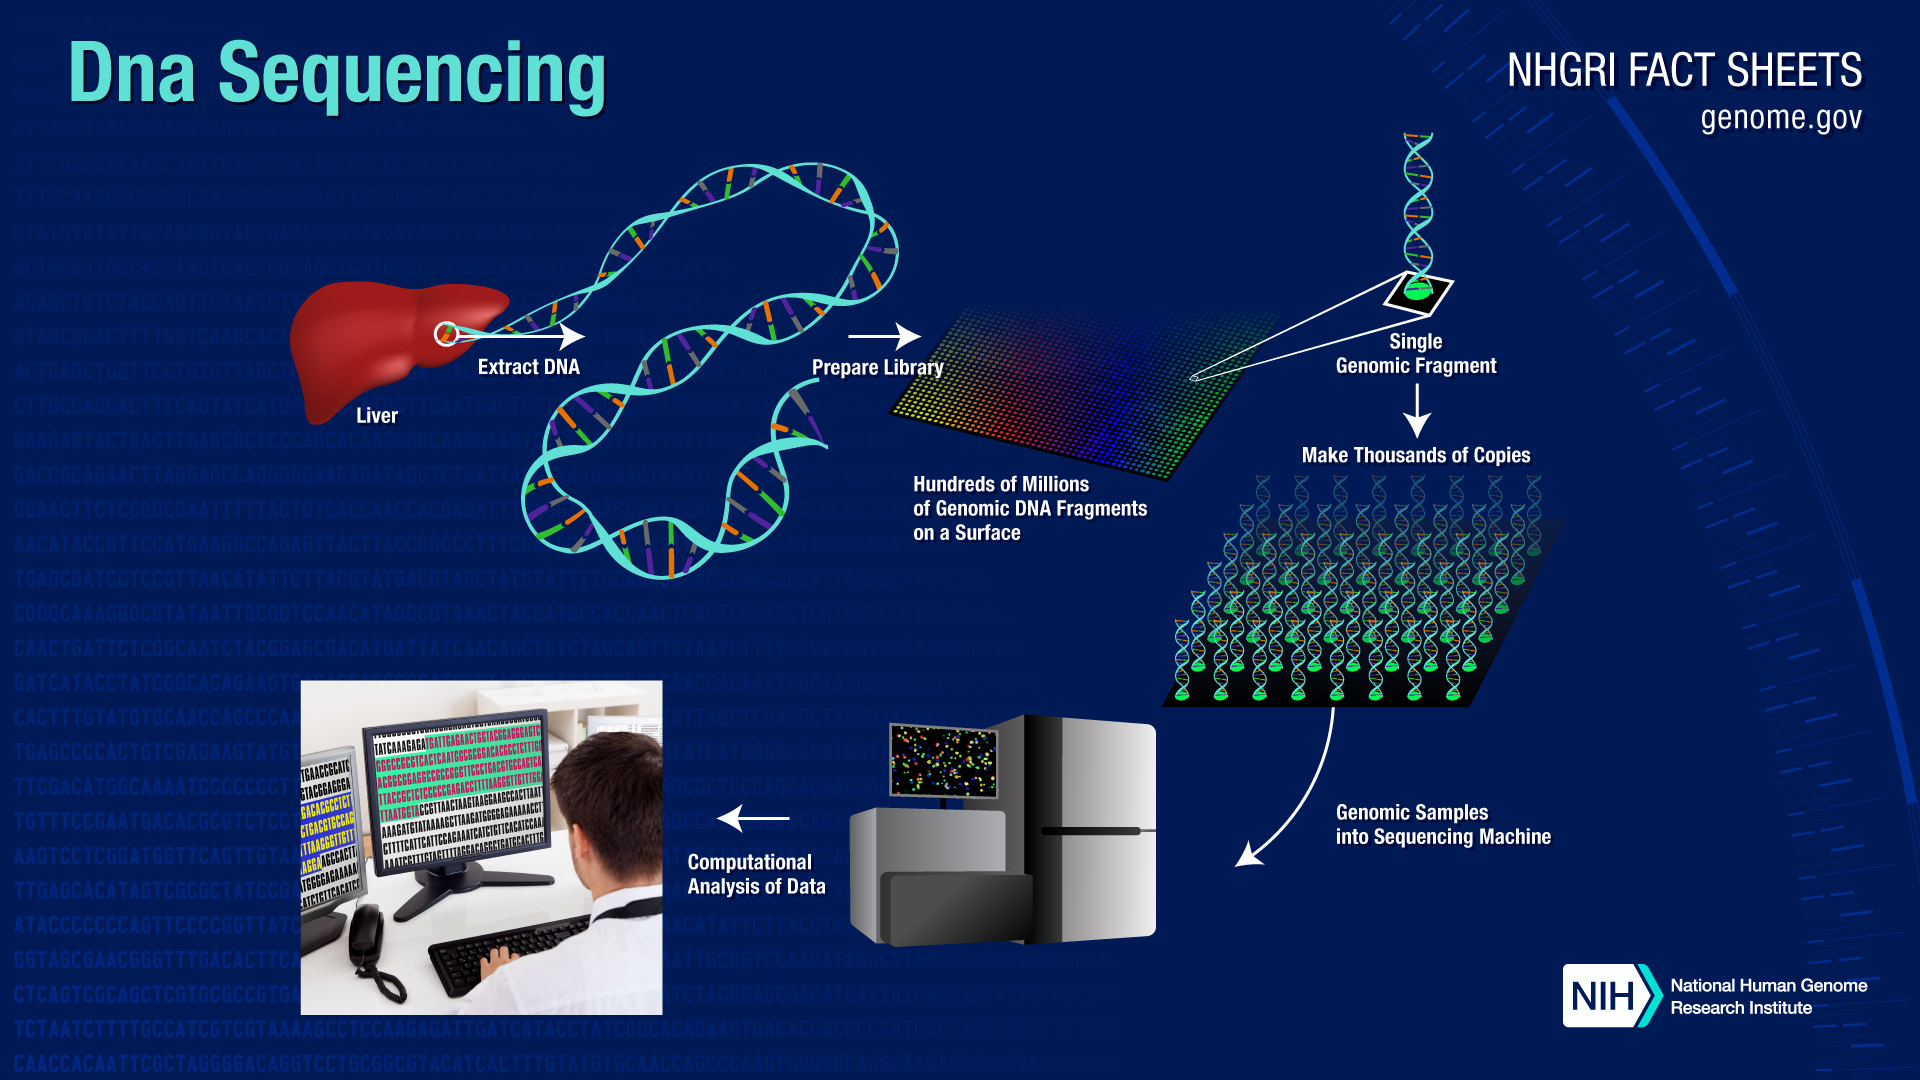


> Looking at the RNA molecules we can know which genes are being expressed at a certain moment in a given sample or samples.


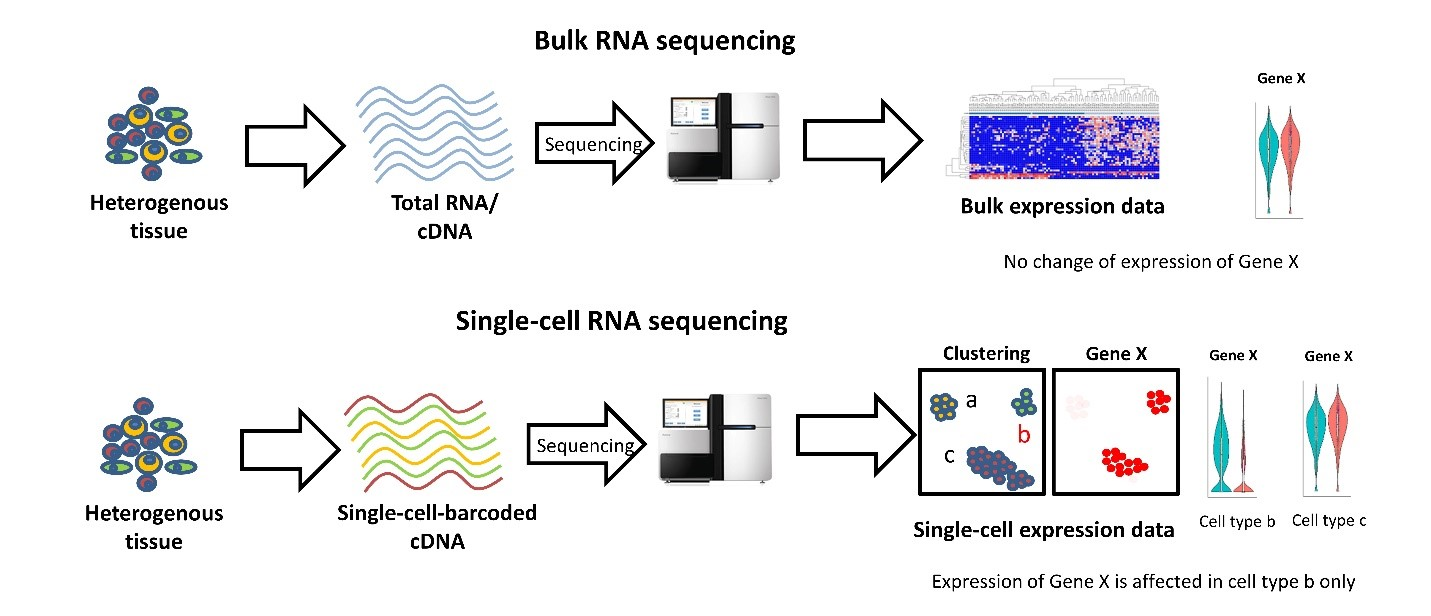

### Applications of scRNA-seq

*   Discovering of new or rare cell types
*   Identifying differential cell composition between healthy/diseased tissues
*   Understanding cell differentiation during development
*   Exploring different cellular dynamics and roles within the same tissue/cancerous tumor





## Preparing and downloading data

Los datos que vamos a analizar hoy consisten de datos de expresión a nivel célula única para aprox 3 mil Células mononucleares de sangre periférica (PBMCs) de un donador sano.


*   Linfocitos ( T cells, B cells, NK cells)
*   Monocitos

Este set de datos está disponile en 10x Genomics ([aqui](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) de esta [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). 

In [1]:
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
pip install scanpy[louvain]

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

# Vamos a usar un objeto AnnData (.h5ad) para guardar nuestros resultados asi como las anotaciones de observaciones y variables
results_file = '/content/data/write/pbmc3k.h5ad'  

os.chdir('/content')
!mkdir data data/write
%cd /content/data

/content/data


Download the data

In [ ]:
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O pbmc3k_filtered_gene_bc_matrices.tar.gz
!tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

Read the data

In [11]:
adata = sc.read_10x_mtx(
    '/content/data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/content-data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [12]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [18]:
adata
# adata.obs # Observations 
# adata.var # Genes
# adata.X # datos - sparse matrix significa que la mayoria es 0
# adata[:3,:3].X.toarray()

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cells, across all cells.

normalizing counts per cell
    finished (0:00:00)


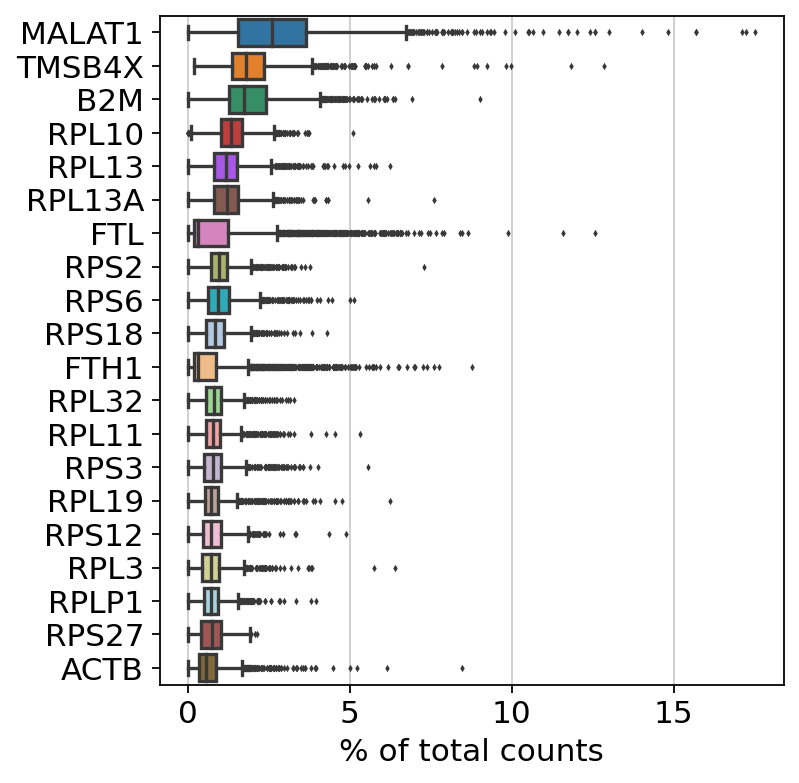

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20)

Basic filtering.

In [20]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [21]:
adata.X

<2700x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2282976 stored elements in Compressed Sparse Row format>

Let us assemple some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [22]:
mito_genes = adata.var_names.str.startswith('MT-')

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Note you can also use the function `pp.calculate_qc_metrics` to compute the fraction of mitochondrial genes and additional measures.

In [24]:
sc.pp.calculate_qc_metrics(adata, inplace = True)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


A violin plot of the computed quality measures.

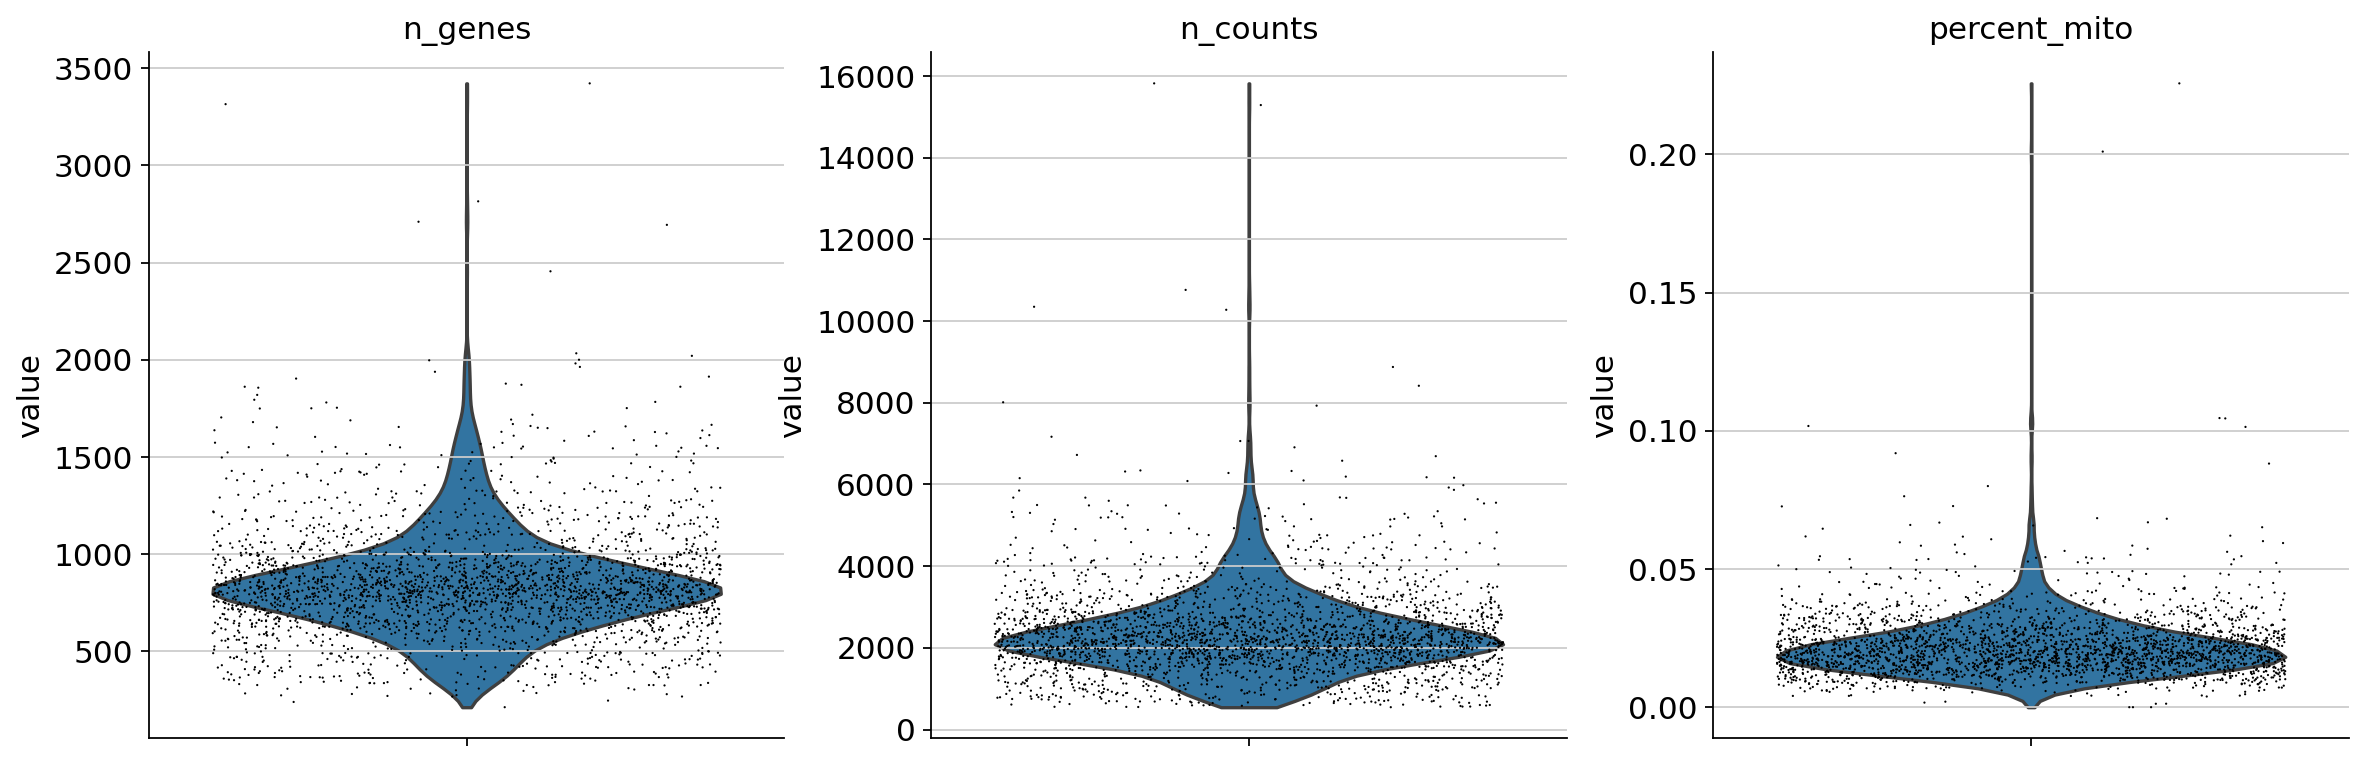

In [ ]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

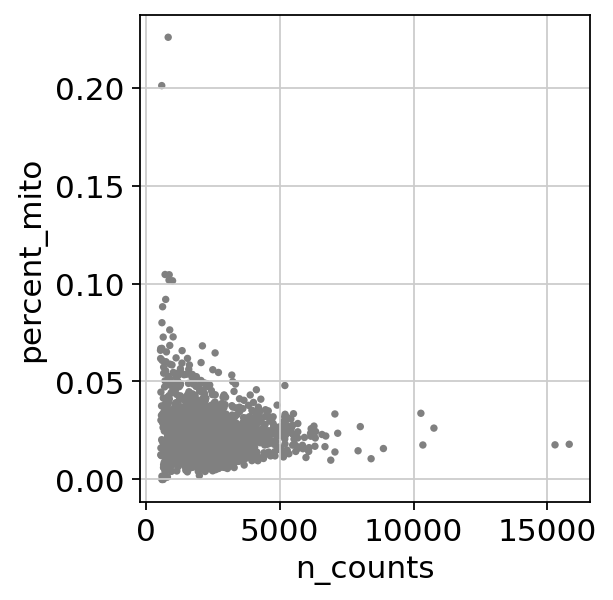

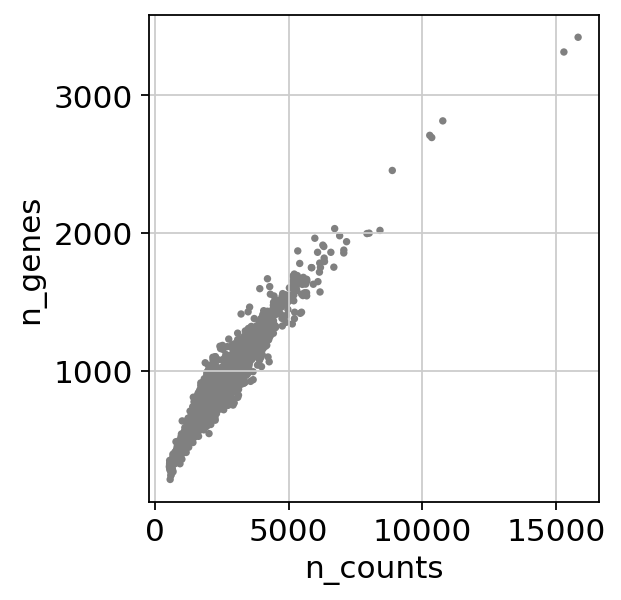

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [ ]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Logarithmize the data to make it more normal/less skwed


In [ ]:
sc.pp.log1p(adata)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object. While many people consider the normalized data matrix as the "relevant data" for visualization and differential testing, some would prefer to store the unnormalized data.

In [ ]:
adata.raw = adata

Identify highly-variable genes.

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


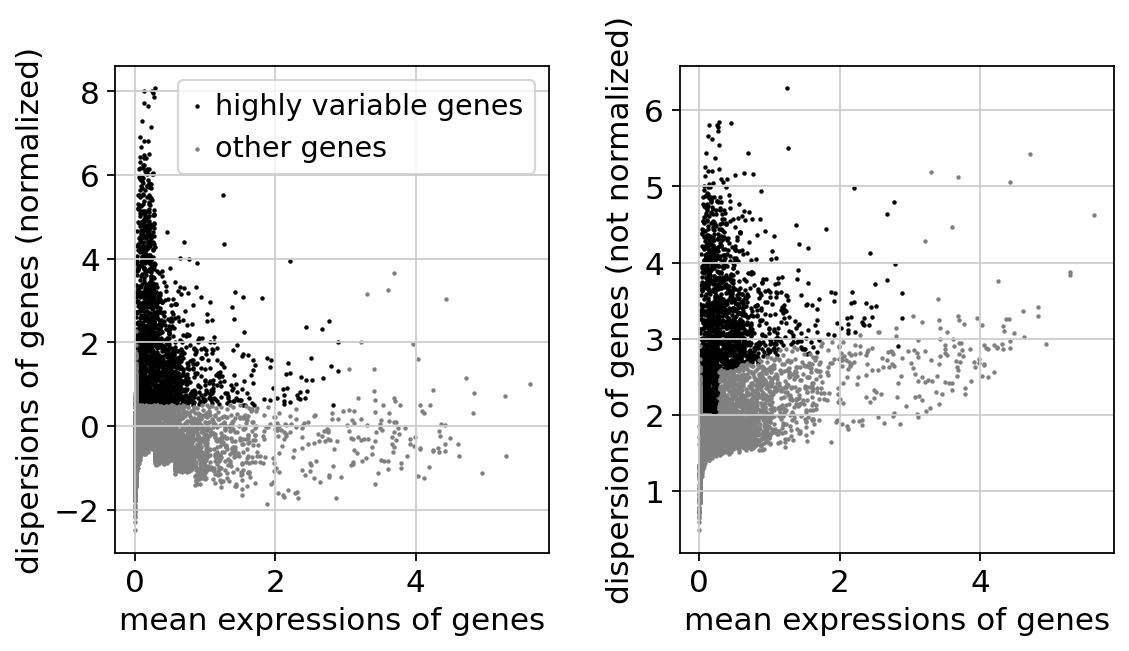

In [ ]:
sc.pl.highly_variable_genes(adata)

Actually do the filtering.

In [ ]:
adata = adata[:, adata.var['highly_variable']]

In [ ]:
adata.var['highly_variable']

TNFRSF4    True
CPSF3L     True
ATAD3C     True
C1orf86    True
RER1       True
           ... 
ICOSLG     True
SUMO3      True
SLC19A1    True
S100B      True
PRMT2      True
Name: highly_variable, Length: 1838, dtype: bool

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [ ]:
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

Trying to set attribute `.var` of view, copying.


regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:08)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [ ]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

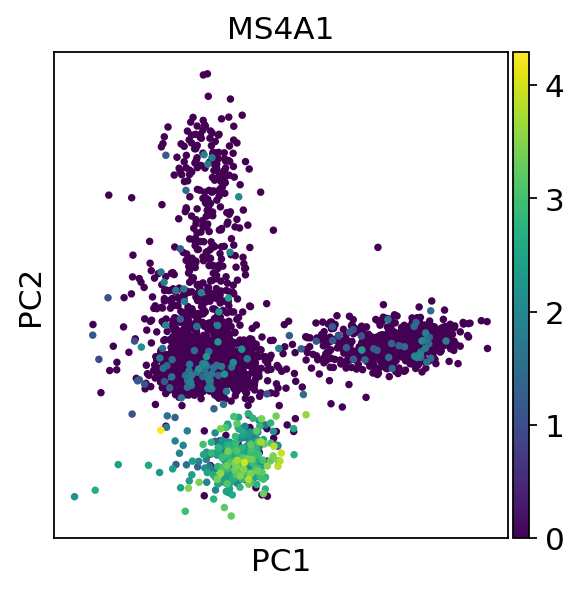

In [ ]:
sc.pl.pca(adata, color='MS4A1')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

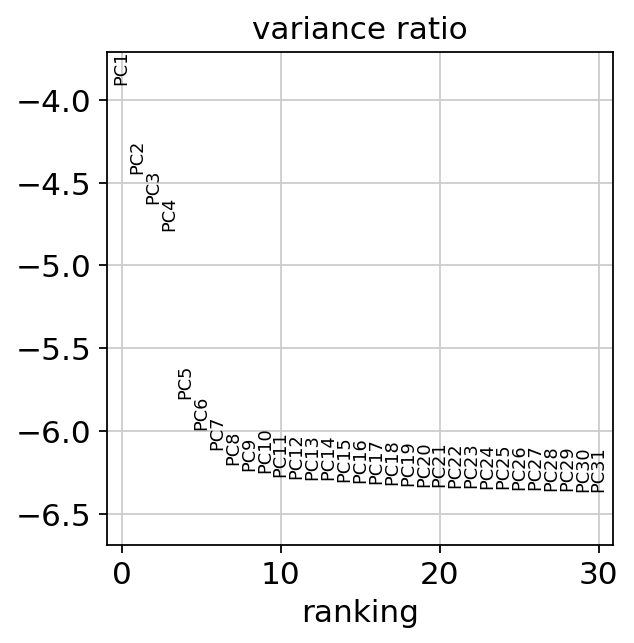

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [ ]:
adata.write(results_file)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)


## Embedding the neighborhood graph

We are embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations that can be corrected by running partition-based graph abstraction (PAGA) first.


In [ ]:
sc.tl.umap(adata)
# sc.tl.paga(adata)
# sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
# sc.tl.umap(adata, init_pos='paga')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


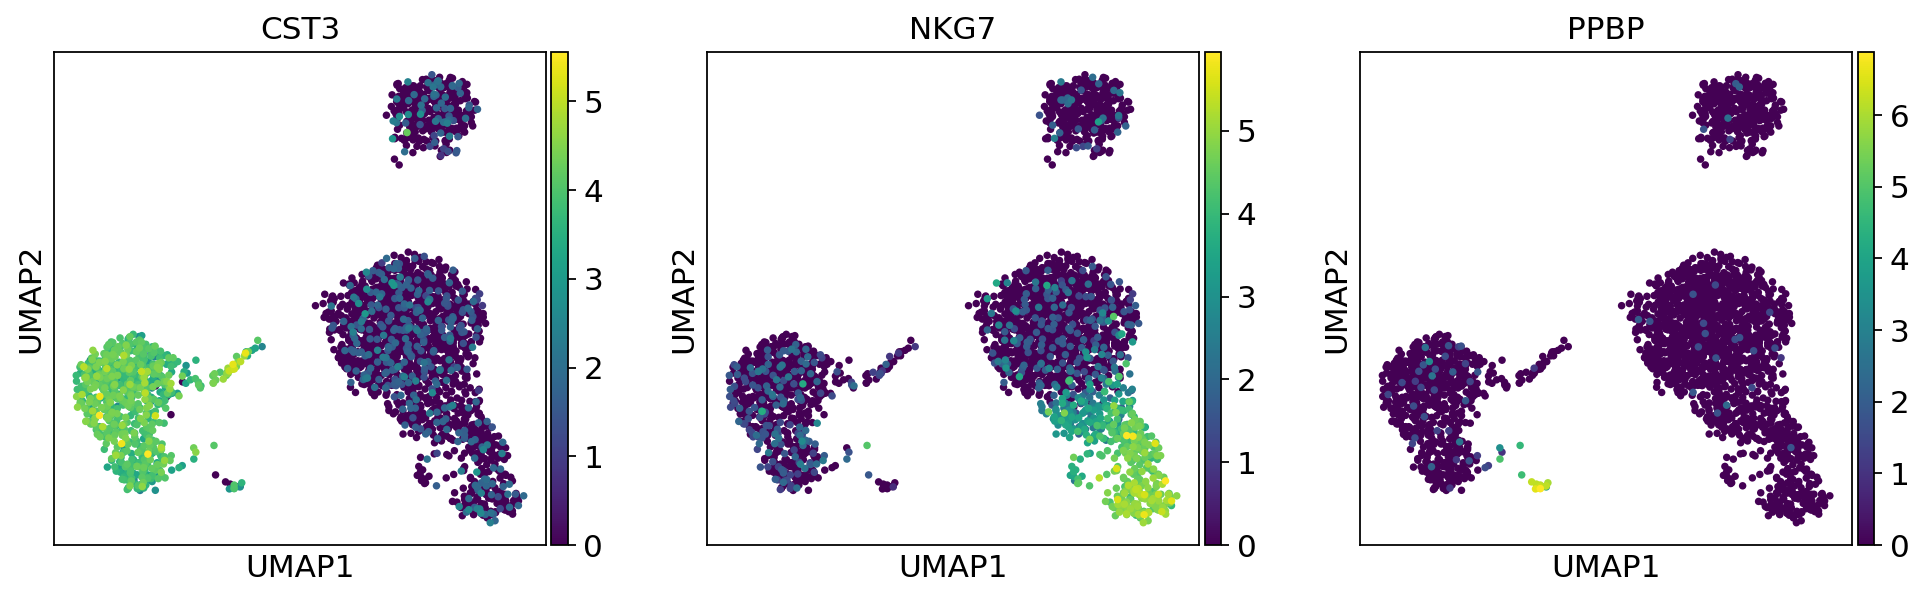

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

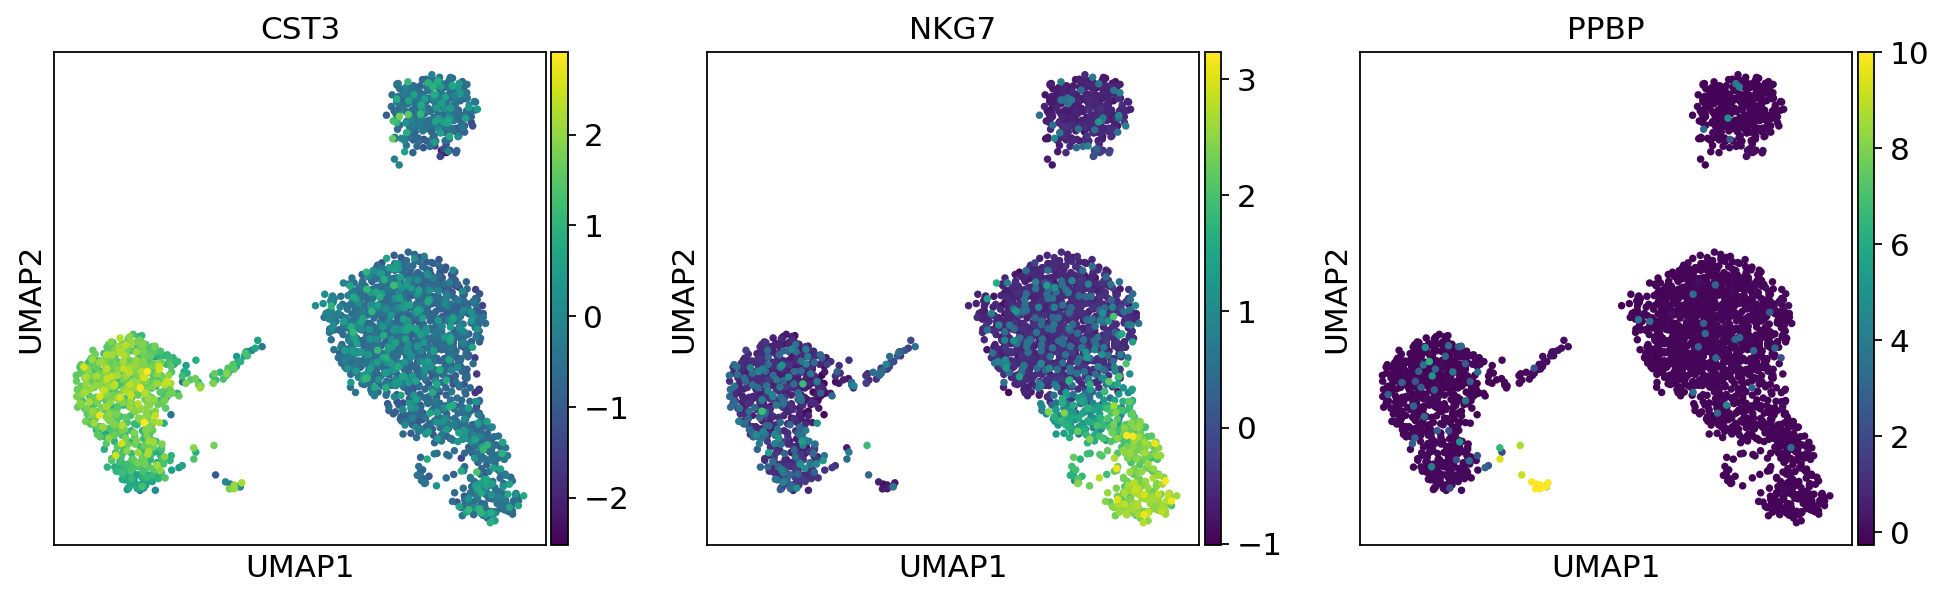

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

The Louvain graph-clustering method (community detection based on optimizing modularity) is recommended for clustering. It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters.

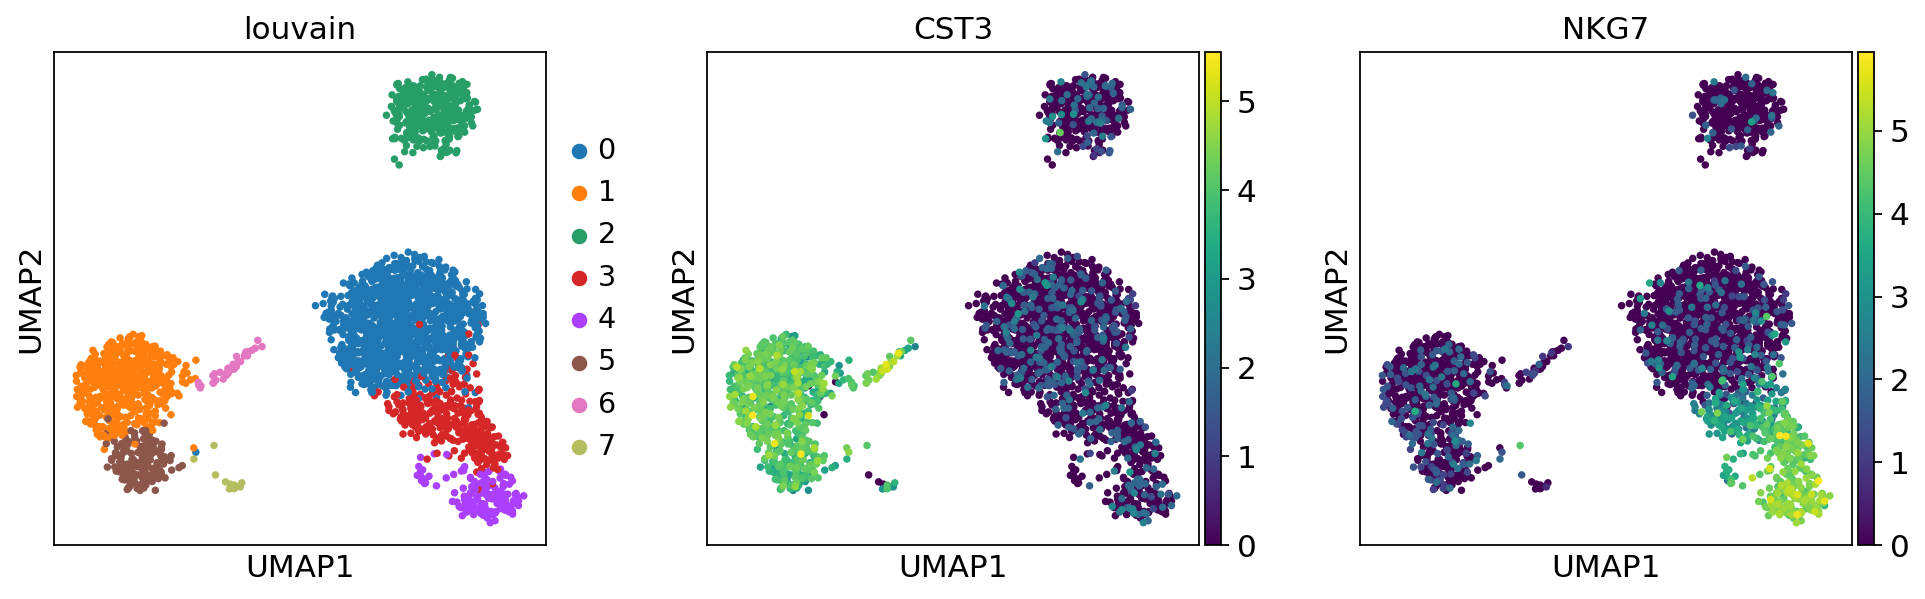

In [ ]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

Save the result.

In [ ]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished (0:00:00)


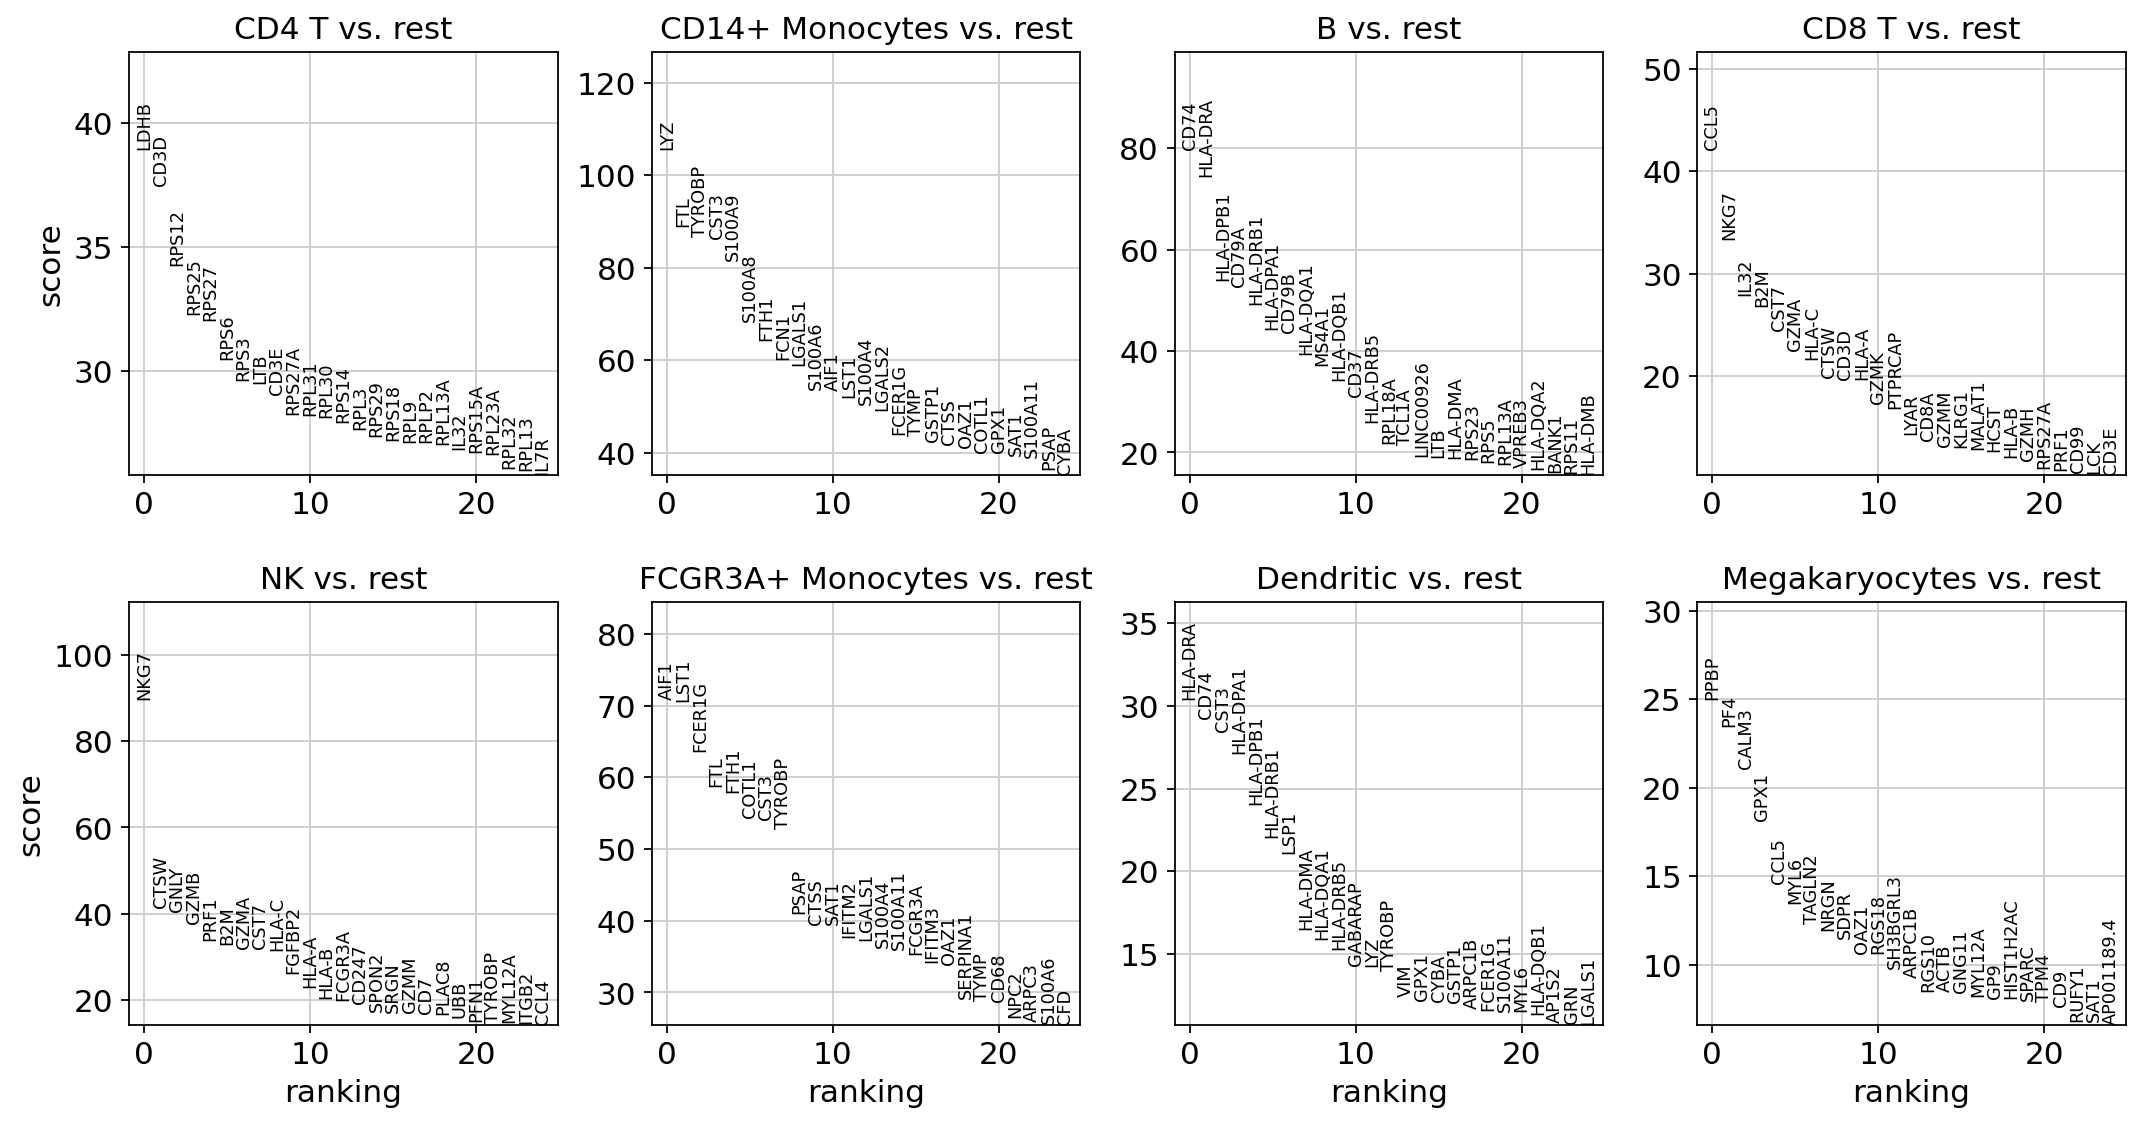

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [ ]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate approach whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:13)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


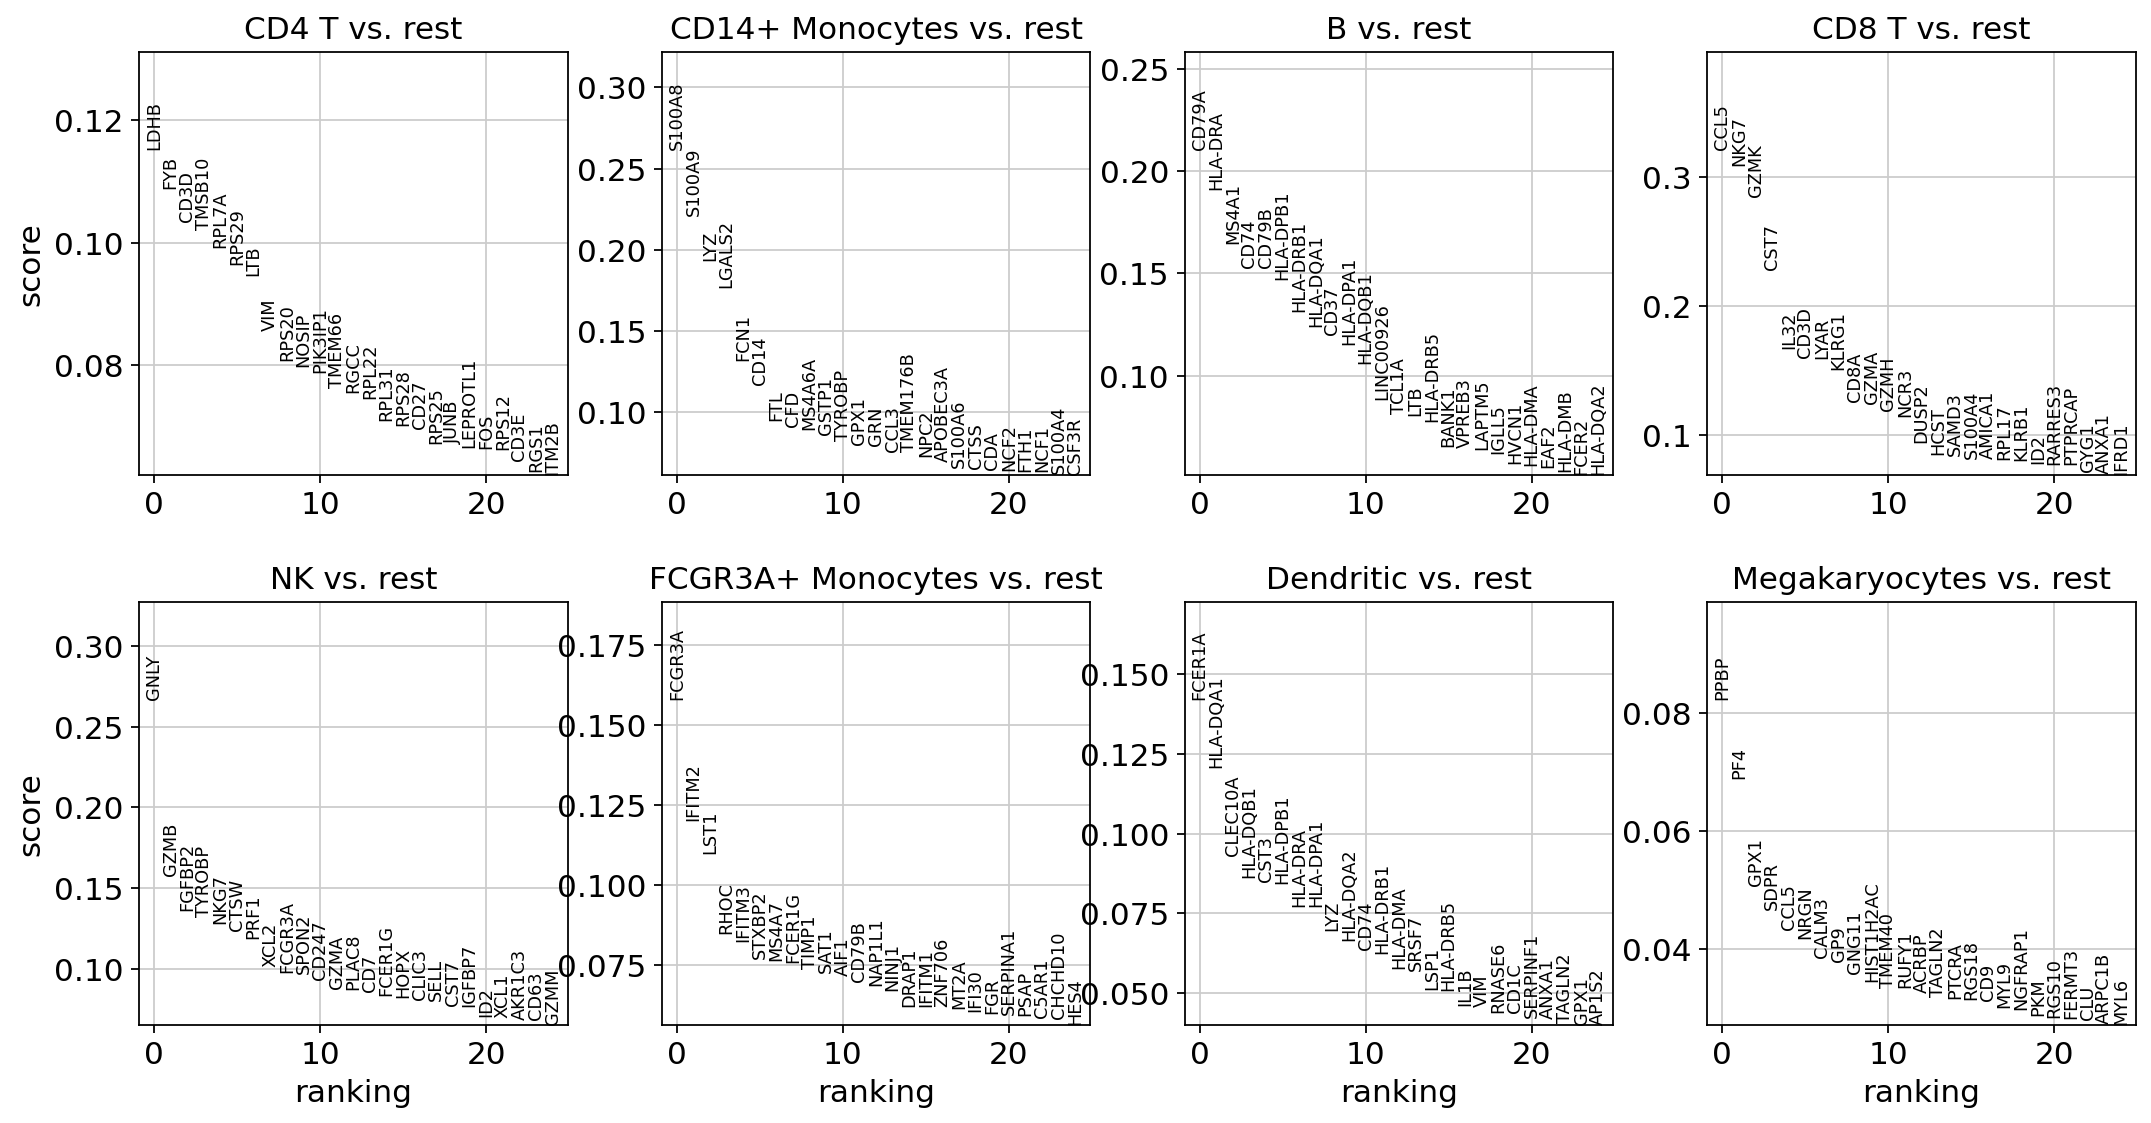

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

CD4 T CD14+ Monocytes         B  ... FCGR3A+ Monocytes Dendritic Megakaryocytes
0   LDHB             LYZ      CD74  ...              AIF1   HLA-DRA           PPBP
1   CD3D             FTL   HLA-DRA  ...              LST1      CD74            PF4
2  RPS12          TYROBP  HLA-DPB1  ...            FCER1G      CST3          CALM3
3  RPS25            CST3     CD79A  ...               FTL  HLA-DPA1           GPX1
4  RPS27          S100A9  HLA-DRB1  ...              FTH1  HLA-DPB1           CCL5

[5 rows x 8 columns]

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

CD4 T_n        CD4 T_p  ... Megakaryocytes_n  Megakaryocytes_p
0    LDHB  2.208014e-262  ...             PPBP      5.028352e-13
1    CD3D  7.691113e-246  ...              PF4      1.229165e-12
2   RPS12  3.832593e-208  ...            CALM3      2.473808e-12
3   RPS25  2.493818e-189  ...             GPX1      2.596295e-11
4   RPS27  1.403745e-186  ...             CCL5      4.517809e-10

[5 rows x 16 columns]

Compare to a single cluster. 

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

ranking genes


ValueError: ignored

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

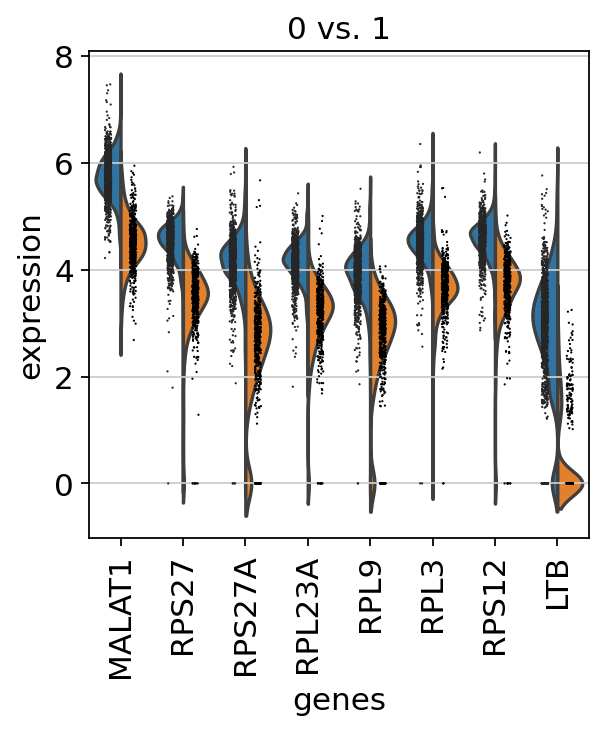

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [ ]:
adata = sc.read(results_file)

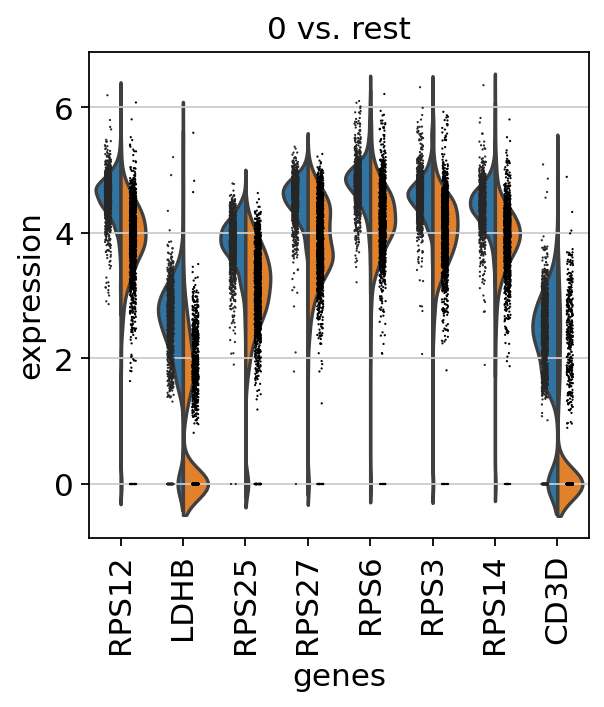

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

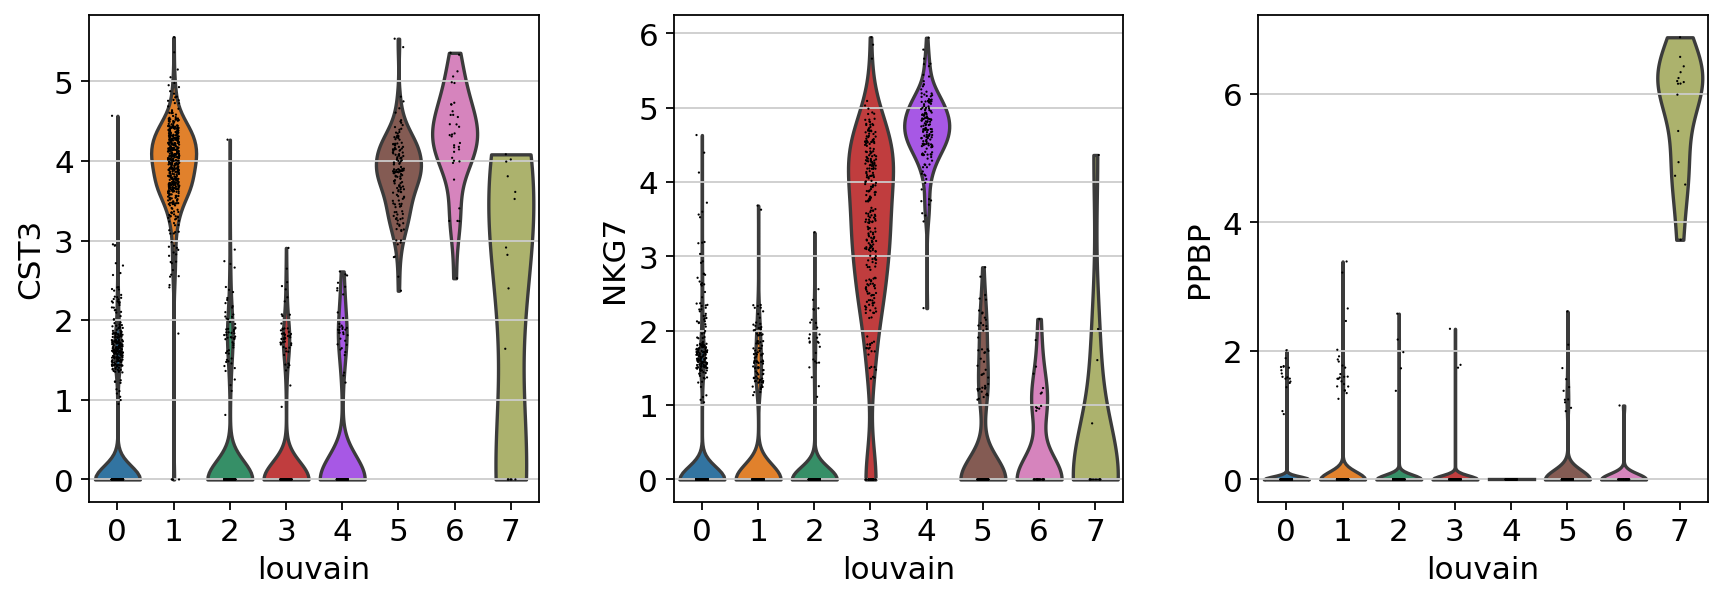

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)
adata.obs['louvain']

AAACATACAACCAC-1              CD4 T
AAACATTGAGCTAC-1                  B
AAACATTGATCAGC-1              CD4 T
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1                 NK
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1                  B
TTTCTACTTCCTCG-1                  B
TTTGCATGAGAGGC-1                  B
TTTGCATGCCTCAC-1              CD4 T
Name: louvain, Length: 2638, dtype: category
Categories (8, object): ['CD4 T', 'CD14+ Monocytes', 'B', 'CD8 T', 'NK', 'FCGR3A+ Monocytes',
                         'Dendritic', 'Megakaryocytes']

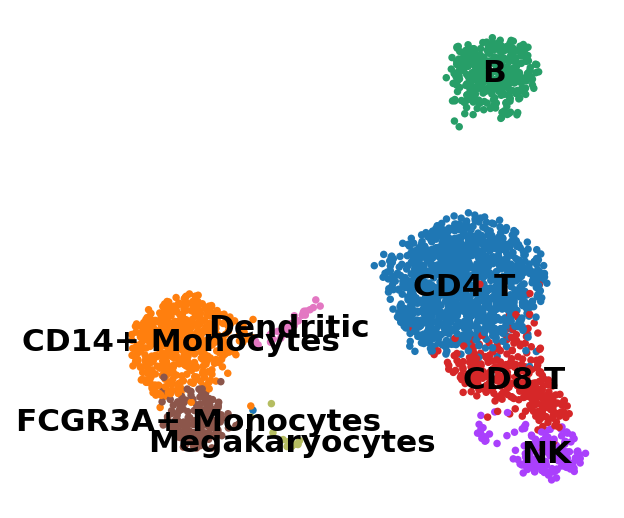

In [ ]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

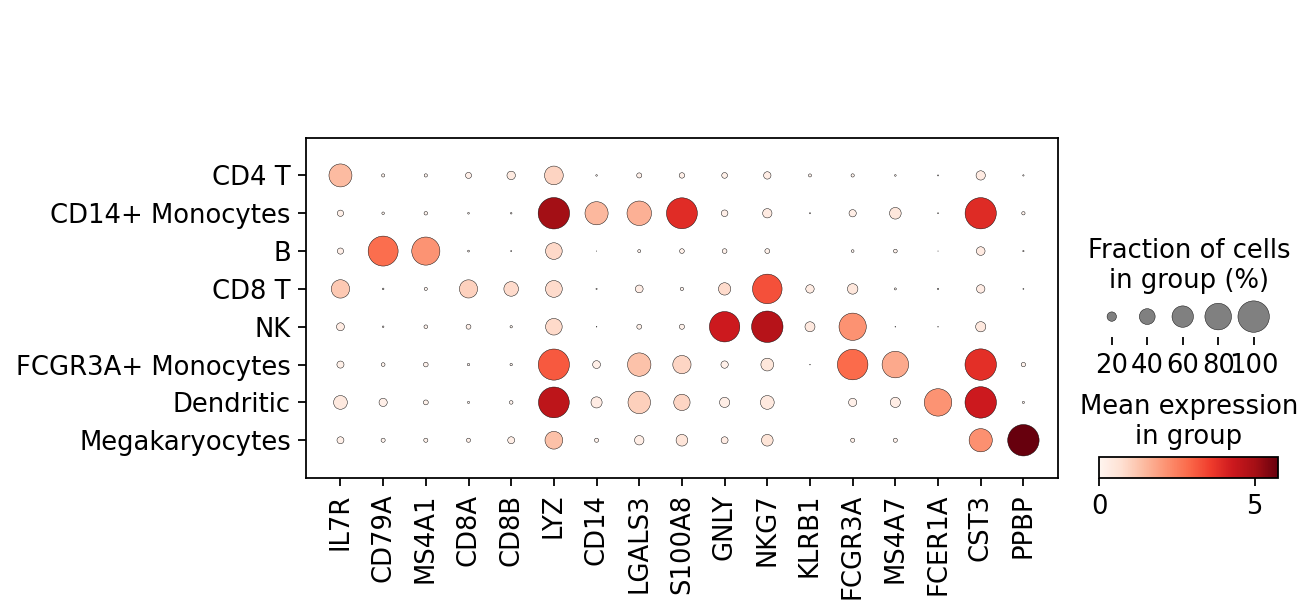

In [ ]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

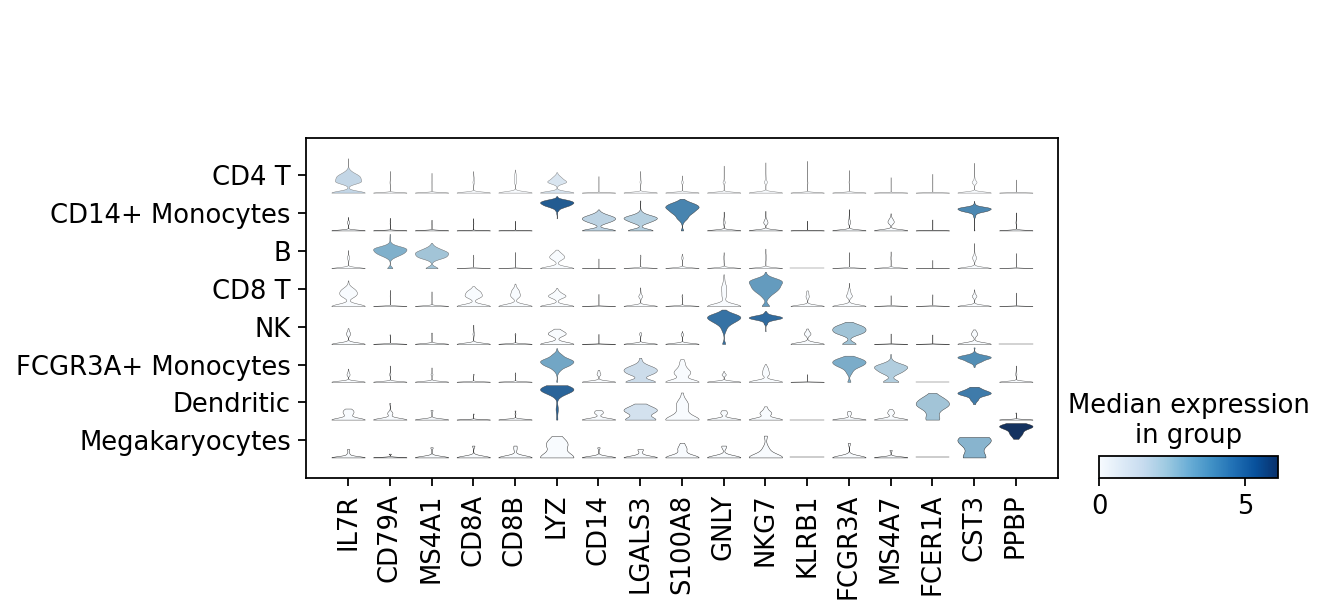

In [ ]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [ ]:
# adata.X = None
# adata.write('/content/data/write/pbmc3k_withoutX.h5ad', compression='gzip')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     '/content/data/write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     '/content/data/write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )

This notebook is based on the [scanpy tutorial](https://icb-scanpy-tutorials.readthedocs-hosted.com/en/latest/pbmc3k.html), so thanks to the creators of scanpy.
  